# Introduction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, LogLocator
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [2]:
df = pd.read_csv("/kaggle/input/nasaexoplanets/cleaned_5250.csv")

*Disclaimer: this notebook is just for fun and practice, no claim on scientific accurateness*

**Brief explanation of each attribute**

* name: planet name most commonly used in literature
* distance: distance from the planet to Earth (in light years)
* stellar_magnitude: absolute magnitude (brightness) of the planet
* planet_type: type of the planet (derived from our solar system)
* discovery_year: year in which planet was first discovered
* mass_multiplier: mass multiplier of the planet with respect to mass_wrt
* mass_wrt: mass of the planet in relation to the planets of our solar system
* radius_multiplier: radius multiplier of the planet with respect to radius_wrt
* radius_wrt: radius of the planet in relation to planets of our solar system
* orbital_radius: radius of the planets orbit around its star (in AU)
* orbital_period: time the planet takes to complete 1 orbit of its star (in years)
* eccentricity: amount by which the planets orbit deviates from a perfect circle
* detection_method: method by which the planet was first identified

**Crucial data for estimating habitability is missing**
* Equilibrium temperature of the planet or effective temperature of its host star
* Radiant flux the planet receives from its host star
* Ergo: final results on potentially habitable Earth-like planets are probably not scientifically accurate

In [3]:
df.tail()

,name,distance,stellar_magnitude,planet_type,discovery_year,mass_multiplier,mass_wrt,radius_multiplier,radius_wrt,orbital_radius,orbital_period,eccentricity,detection_method
5245,XO-7 b,764.0,10.521,Gas Giant,2019,0.709,Jupiter,1.373,Jupiter,0.04421,0.007940,0.04,Transit
5246,YSES 2 b,357.0,10.885,Gas Giant,2021,6.300,Jupiter,1.140,Jupiter,115.00000,1176.500000,0.00,Direct Imaging
5247,YZ Ceti b,12.0,12.074,Terrestrial,2017,0.700,Earth,0.913,Earth,0.01634,0.005476,0.06,Radial Velocity
5248,YZ Ceti c,12.0,12.074,Super Earth,2017,1.140,Earth,1.050,Earth,0.02156,0.008487,0.00,Radial Velocity
5249,YZ Ceti d,12.0,12.074,Super Earth,2017,1.090,Earth,1.030,Earth,0.02851,0.012868,0.07,Radial Velocity


# Data Preprocessing

Problem: 
* mass & radius of all planets are given in multiples of the mass & radius of Earth OR Jupiter               
* we need mass & radius of all planets to be given as multiples of the mass & radius of Earth

Solution: 
* do not change values for rows where mass_wrt & radius_wrt is Earth
* calculate new mass multiplier for rows where mass_wrt is Jupiter
* calculate new radius multiplier for rows where radius_wrt is Jupiter
* rename mass_multiplier to mass_earth and radius_multiplier to radius_earth


In [4]:
# Jupiter is 317.82838 times as massive as Earth
def calc_mass_earth(x):
    if x["mass_wrt"] == "Earth":
        return x["mass_multiplier"]
    elif x["mass_wrt"] == "Jupiter":
        return x["mass_multiplier"] * 317.82838

# Jupiters radius is 11.209 times larger than Earths radius
def calc_radius_earth(x):
    if x["radius_wrt"] == "Earth":
        return x["radius_multiplier"]
    elif x["radius_wrt"] == "Jupiter":
        return x["radius_multiplier"] * 11.209 

df["mass_multiplier"] = df.apply(calc_mass_earth, axis=1)
df["radius_multiplier"] = df.apply(calc_radius_earth, axis=1)
df = df.rename(columns = {"mass_multiplier": "mass_earth", "radius_multiplier": "radius_earth"})

In [5]:
# Dropping irrelevant columns
df = df.drop(columns = ["stellar_magnitude", "mass_wrt", "radius_wrt"])

# Checking for null values
df.isna().any()

name                False
distance             True
planet_type         False
discovery_year      False
mass_earth           True
radius_earth         True
orbital_radius       True
orbital_period      False
eccentricity        False
detection_method    False
dtype: bool

In [6]:
# Dropping rows with null values for relevant attributes
df = df.dropna(subset = ["mass_earth", "radius_earth"])

df.describe(include="all")

,name,distance,planet_type,discovery_year,mass_earth,radius_earth,orbital_radius,orbital_period,eccentricity,detection_method
count,5215,5198.000000,5215,5215.000000,5215.000000,5215.000000,4933.000000,5.215000e+03,5215.000000,5215
unique,5215,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,11
top,11 Comae Berenices b,NaN,Neptune-like,NaN,NaN,NaN,NaN,NaN,NaN,Transit
freq,1,NaN,1825,NaN,NaN,NaN,NaN,NaN,NaN,3927
mean,NaN,2164.641016,NaN,2015.739597,457.464923,5.607549,6.990528,4.823558e+02,0.063739,NaN
std,NaN,3252.374090,NaN,4.305650,3762.884312,5.313928,139.065816,1.686071e+04,0.141412,NaN
min,NaN,4.000000,NaN,1992.000000,0.020000,0.296000,0.005800,5.475702e-04,-0.520000,NaN
25%,NaN,384.250000,NaN,2014.000000,3.950000,1.750000,0.053200,1.259411e-02,0.000000,NaN
50%,NaN,1370.000000,NaN,2016.000000,8.450000,2.734996,0.102700,3.449692e-02,0.000000,NaN
75%,NaN,2770.000000,NaN,2018.500000,152.827777,11.545270,0.282900,1.423682e-01,0.060000,NaN


In [7]:
# Eccentricity is always a non-negative number
# Treating negative values as sign errors and converting to absolute values
df["eccentricity"] = df["eccentricity"].apply(abs)

# Visualization & Exploration

In [8]:
# Converting attributes with values differing in magnitude to logarithmic representation
log_mass_earth = np.log10(df["mass_earth"])
log_radius_earth = np.log10(df["radius_earth"])
log_orbital_period = np.log10(df["orbital_period"])
log_orbital_radius = np.log10(df["orbital_radius"])

# Function for converting axis ticks from logarithmic to linear notation
def log_to_lin(x, pos):
    return f"{10**x:.2f}"

df.tail(10)

,name,distance,planet_type,discovery_year,mass_earth,radius_earth,orbital_radius,orbital_period,eccentricity,detection_method
5240,XO-2 S c,494.0,Gas Giant,2014,435.424881,13.562890,0.47560,0.330732,0.15,Radial Velocity
5241,XO-3 b,695.0,Gas Giant,2007,2316.968890,15.804690,0.04760,0.008761,0.29,Transit
5242,XO-4 b,889.0,Gas Giant,2008,451.316300,14.011250,0.05524,0.011225,0.00,Transit
5243,XO-5 b,901.0,Gas Giant,2008,378.215772,12.778260,0.05150,0.011499,0.00,Transit
5244,XO-6 b,768.0,Gas Giant,2016,1398.444872,23.202630,0.08150,0.010404,0.00,Transit
5245,XO-7 b,764.0,Gas Giant,2019,225.340321,15.389957,0.04421,0.007940,0.04,Transit
5246,YSES 2 b,357.0,Gas Giant,2021,2002.318794,12.778260,115.00000,1176.500000,0.00,Direct Imaging
5247,YZ Ceti b,12.0,Terrestrial,2017,0.700000,0.913000,0.01634,0.005476,0.06,Radial Velocity
5248,YZ Ceti c,12.0,Super Earth,2017,1.140000,1.050000,0.02156,0.008487,0.00,Radial Velocity
5249,YZ Ceti d,12.0,Super Earth,2017,1.090000,1.030000,0.02851,0.012868,0.07,Radial Velocity


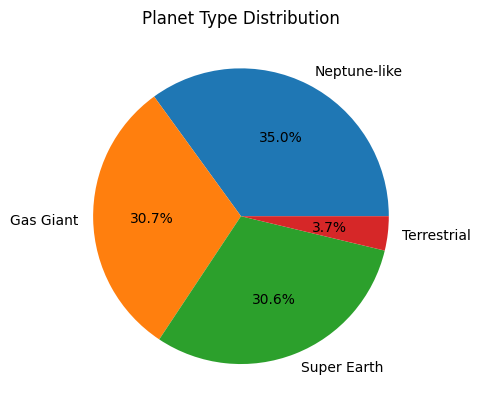

In [9]:
# Planet type piechart
planet_counts = df["planet_type"].value_counts()
plt.pie(planet_counts, labels=planet_counts.index, autopct="%1.1f%%")
plt.title("Planet Type Distribution")
plt.show()

**Potentially habitable**
* Terrestrial (0.5 ~ 2 Earth masses)
* Super Earths (2 ~ 10 Earth masses)

**Unlikely to be habitable**
* Neptune-like (10 ~ 50 Earth masses)
* Gas Giant (> 50 Earth masses)

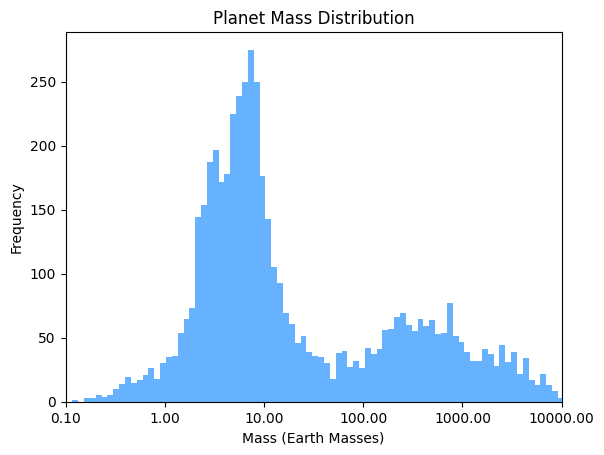

In [10]:
# Planet mass histogram
plt.hist(log_mass_earth, bins=120, color="#66B2FF")
plt.title("Planet Mass Distribution")
plt.xlabel("Mass (Earth Masses)")
plt.ylabel("Frequency")
plt.xlim(-1, 4)
plt.gca().xaxis.set_major_formatter(FuncFormatter(log_to_lin))
plt.show()

**Bimodal distribution of planet mass**
* First peak caused by Super Earths and Neptunian planets
* Second peak caused by Gas Giants

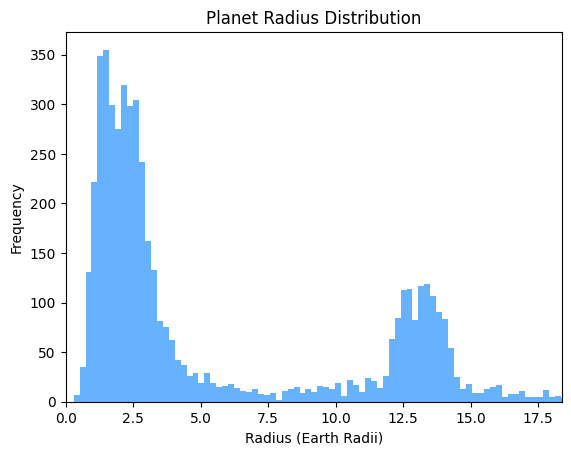

In [11]:
# Planet radius histogram
plt.hist(df["radius_earth"], bins=350, color="#66B2FF")
plt.title("Planet Radius Distribution")
plt.xlabel("Radius (Earth Radii)")
plt.ylabel("Frequency")
plt.xlim(0, df["radius_earth"].quantile(0.99))
plt.show()

**Bimodal distribution of planet radius**
* First peak caused by Terrestrial, Super Earths and Neptunian planets
* Second peak caused by Gas Giants

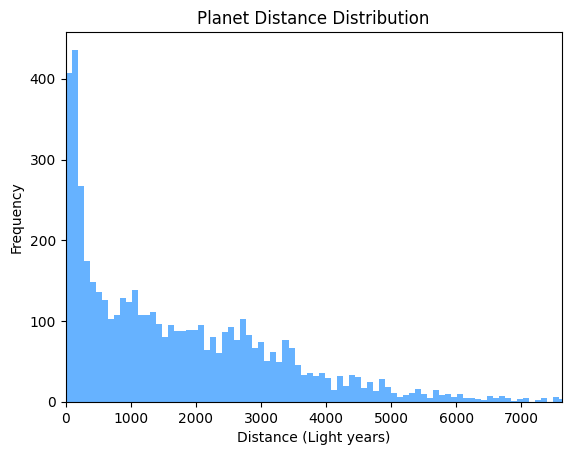

In [12]:
# Planet distance histogram
plt.hist(df["distance"].dropna(), bins=300, color="#66B2FF")
plt.title("Planet Distance Distribution")
plt.xlabel("Distance (Light years)")
plt.ylabel("Frequency")
plt.xlim(0, df["distance"].quantile(0.97))
plt.show()

**Right-skewed distribution of planet distance**
* The further away a planet, the harder it is to detect
* Significant drop-off after 100 light years

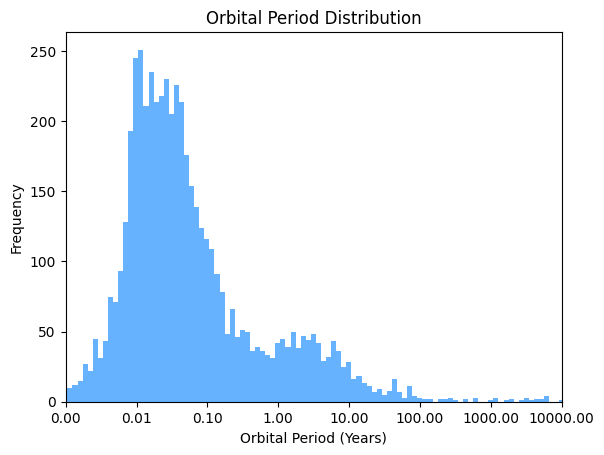

In [13]:
# Orbital period histogram
plt.hist(log_orbital_period, bins=130, color="#66B2FF")
plt.title("Orbital Period Distribution")
plt.xlabel("Orbital Period (Years)")
plt.ylabel("Frequency")
plt.xlim(-3, 4)
plt.gca().xaxis.set_major_formatter(FuncFormatter(log_to_lin))
plt.show()

**Distribution of orbital period**
* Dominated by orbital periods shorter than that of Earth
* Possible smaller second peak from 1 ~ 10 years

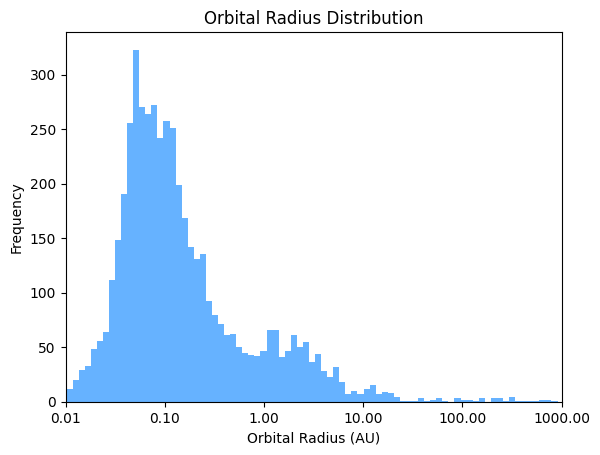

In [14]:
# Orbital radius histogram
plt.hist(log_orbital_radius, bins=100, color="#66B2FF")
plt.title("Orbital Radius Distribution")
plt.xlabel("Orbital Radius (AU)")
plt.ylabel("Frequency")
plt.xlim(-2, 3)
plt.gca().xaxis.set_major_formatter(FuncFormatter(log_to_lin))
plt.show()

**Distribution of orbital radius**
* Dominated by orbital radii smaller than that of Earth
* Possible smaller second peak from 1 ~ 10 AU

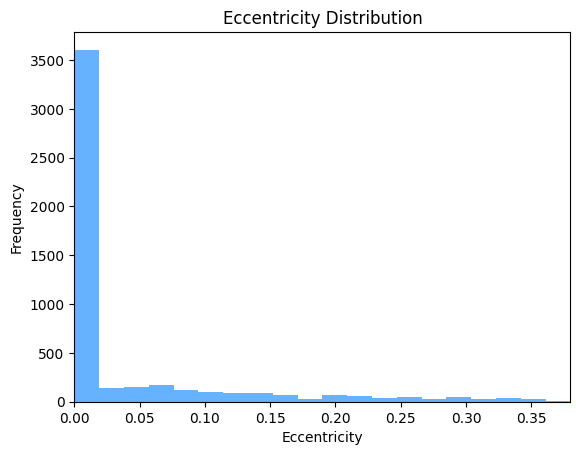

In [15]:
# Eccentricity histogram
plt.hist(df["eccentricity"], bins=50, color="#66B2FF")
plt.title("Eccentricity Distribution")
plt.xlabel("Eccentricity")
plt.ylabel("Frequency")
plt.xlim(0, df["eccentricity"].quantile(0.95))
plt.show()

**Heavily right-skewed distribution of eccentricity**
* 3550 planets have a reported eccentricity of 0.000
* Orbits can not be perfectly circular in the real world
* Values are probably rounded or have precision limitations

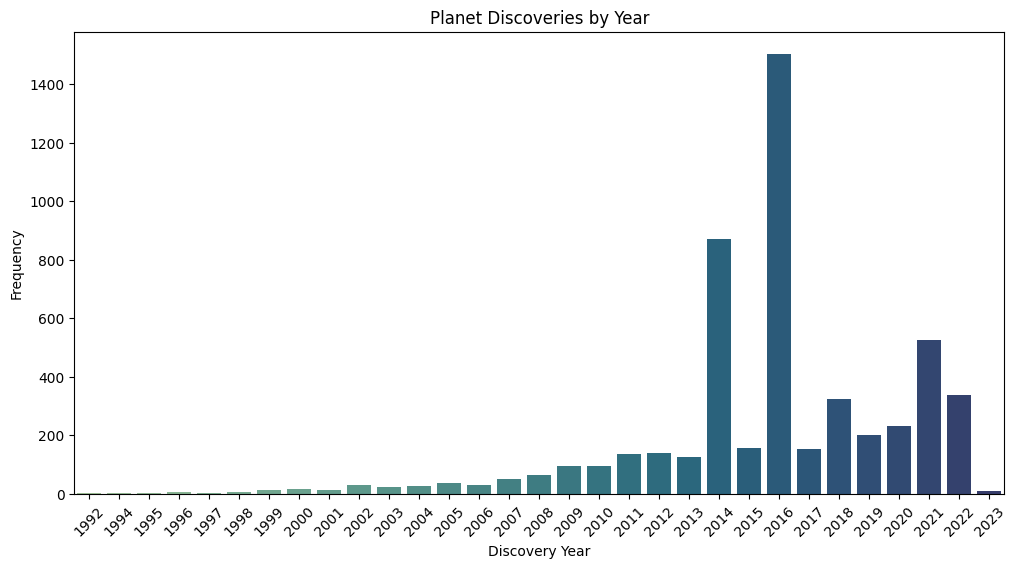

In [16]:
# Discovery year barplot
plt.figure(figsize=(12, 6))
sns.countplot(x="discovery_year", data=df, palette="crest")
plt.title("Planet Discoveries by Year")
plt.xlabel("Discovery Year")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

* Kepler space telescope active from 2009 ~ 2018
* Discovered over 2600 exoplanets

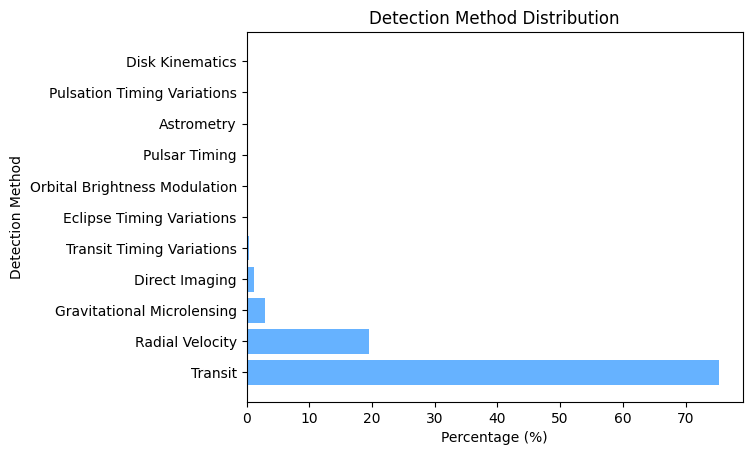

In [17]:
# Detection method barplot
detection_ratios = df["detection_method"].value_counts() / len(df) * 100
plt.barh( detection_ratios.index, detection_ratios, color="#66B2FF")
plt.title("Detection Method Distribution")
plt.ylabel("Detection Method")
plt.xlabel("Percentage (%)")
plt.show()

* Transit method used by Kepler space telescope
* Radial velocity was more effective until 2012

# Discovering Interesting Correlations

*Disclaimer: only visual analysis, confirming the significance of these correlations would require statistical testing*

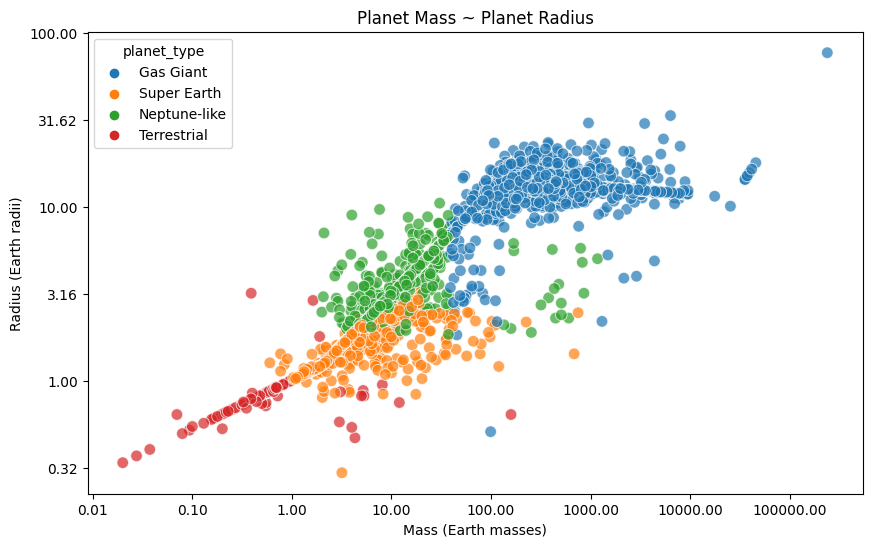

In [18]:
# Planet Mass ~ Planet Radius
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x=log_mass_earth, y=log_radius_earth, hue="planet_type", alpha=0.7, s=70)
plt.title("Planet Mass ~ Planet Radius")
plt.xlabel("Mass (Earth masses)")
plt.ylabel("Radius (Earth radii)")
plt.gca().xaxis.set_major_formatter(FuncFormatter(log_to_lin))
plt.gca().yaxis.set_major_formatter(FuncFormatter(log_to_lin))
plt.show()

**Relationship between planet mass and planet radius**
* General trend: the higher the planet mass, the higher the planet radius tends to be
* However, relationship depends on planet composition & gravitional compression
* Rocky planets have sublinear mass-radius correlation (radius increases at slower rate than mass)
* Gas planets have superlinear mass-radius correlation (radius increases at faster rate than mass)

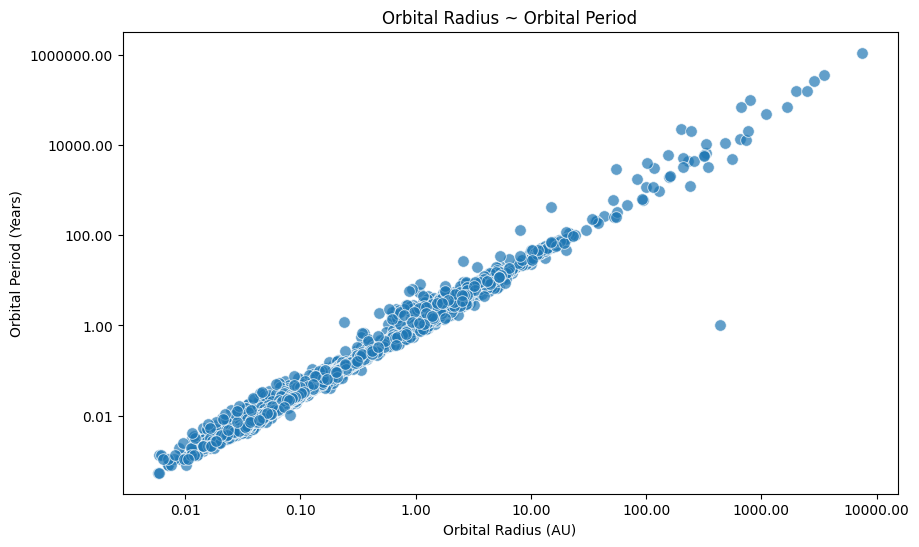

In [19]:
# Orbital Radius ~ Orbital Period
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x=log_orbital_radius, y=log_orbital_period, alpha=0.7, s=70)
plt.title("Orbital Radius ~ Orbital Period")
plt.xlabel("Orbital Radius (AU)")
plt.ylabel("Orbital Period (Years)")
plt.gca().xaxis.set_major_formatter(FuncFormatter(log_to_lin))
plt.gca().yaxis.set_major_formatter(FuncFormatter(log_to_lin))
plt.show()

**Relationship between orbital radius and orbital period**
* General trend: the higher the mean distance from planet to host star, the longer one orbit takes
* Relationship is superlinear (orbital period increases at faster rate than orbital radius)
* One interesting outlier with high orbital radius and low orbital period exists

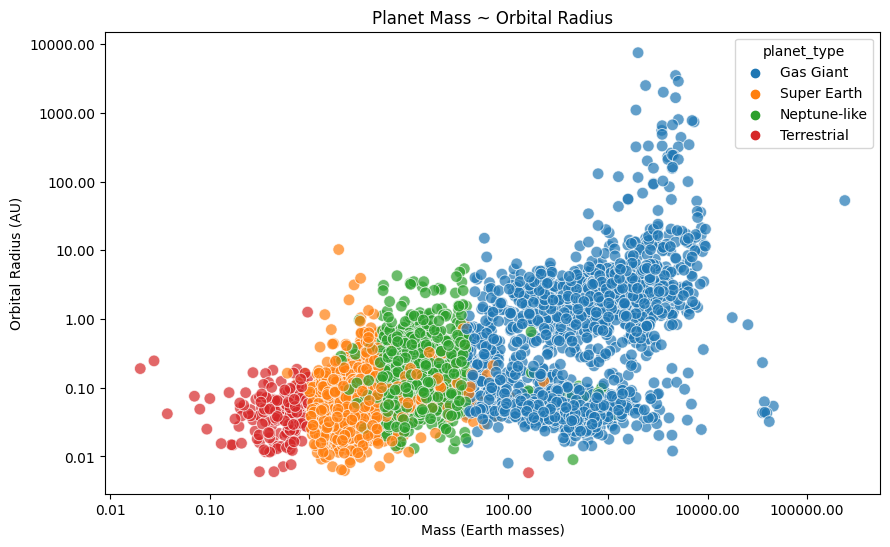

In [20]:
# Planet Mass ~ Orbital Radius
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x=log_mass_earth, y=log_orbital_radius, hue="planet_type", alpha=0.7, s=70)
plt.title("Planet Mass ~ Orbital Radius")
plt.xlabel("Mass (Earth masses)")
plt.ylabel("Orbital Radius (AU)")
plt.gca().xaxis.set_major_formatter(FuncFormatter(log_to_lin))
plt.gca().yaxis.set_major_formatter(FuncFormatter(log_to_lin))
plt.show()

**No direct relationship between planet mass and orbital radius**
* Orbital radius depends primarily on mass of host star and orbital period of planet
* However, rocky planets tend to have lower orbital radius than gas planets
* According to nebular hypothesis, rocky planets form much closer their host star than gas planets
* Gas giants orbiting their host star at small distances are unlikely to have formed there originally, but instead migrated there during or after formation (Hot Jupiters)
* Interesting group of gas giants with much higher orbital radius than planets of similar mass

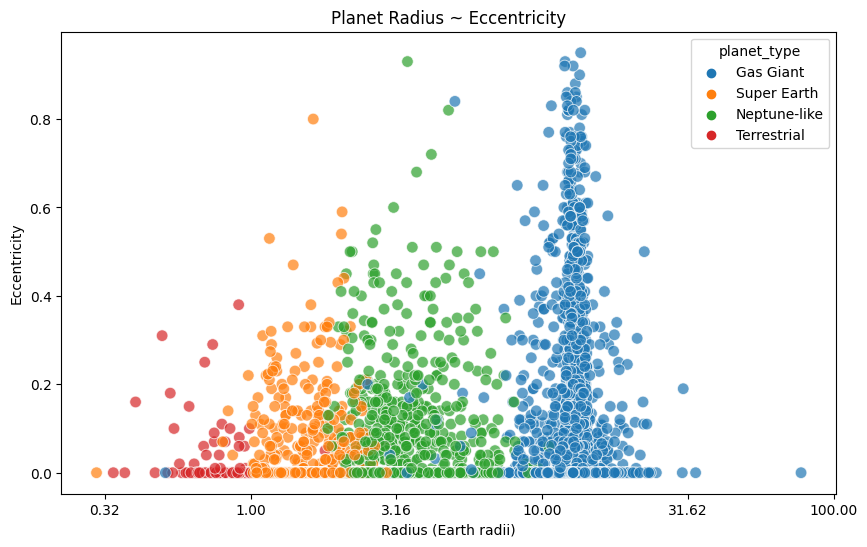

In [21]:
# Planet Radius ~ Eccentricity
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x=log_radius_earth, y="eccentricity", hue="planet_type", alpha=0.7, s=70)
plt.title("Planet Radius ~ Eccentricity")
plt.xlabel("Radius (Earth radii)")
plt.ylabel("Eccentricity")
plt.gca().xaxis.set_major_formatter(FuncFormatter(log_to_lin))
plt.show()

**No direct relationship between planet radius and eccentricity**
* Eccentricity depends on orbital pertubations and gravitational interactions
* Low radius planets have lower variation in eccentricity and tend to have low eccentricity
* High radius planets have higher variation in eccentricity

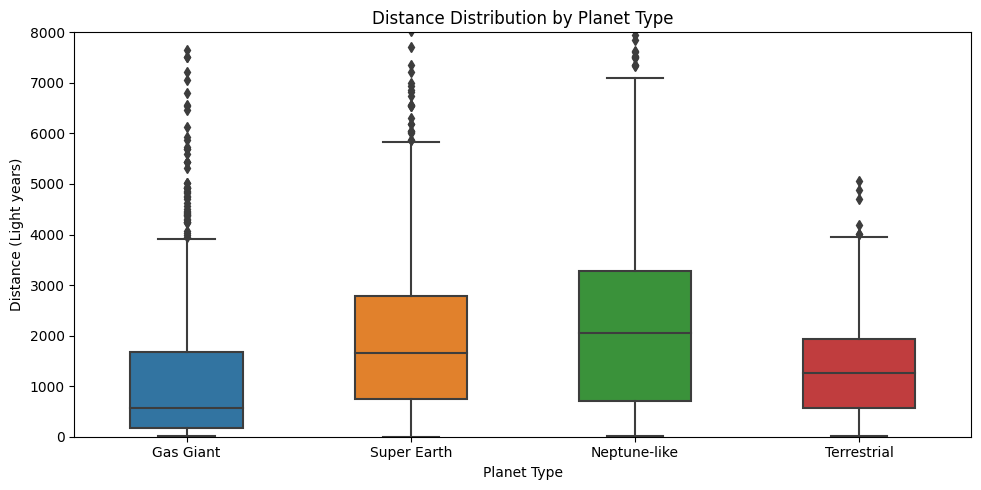

In [22]:
# Planet Type ~ Distance
plt.figure(figsize=(10, 5))
sns.boxplot(x="planet_type", y="distance", data=df, width=0.5)
plt.title("Distance Distribution by Planet Type")
plt.xlabel("Planet Type")
plt.ylabel("Distance (Light years)")
plt.tight_layout()
plt.ylim(0, 8000)
plt.show()

**Gas giants and terrestrial planets stand out**
* Lower median than other planet types
* Super earths and neptunian planets have wider IQR and total range

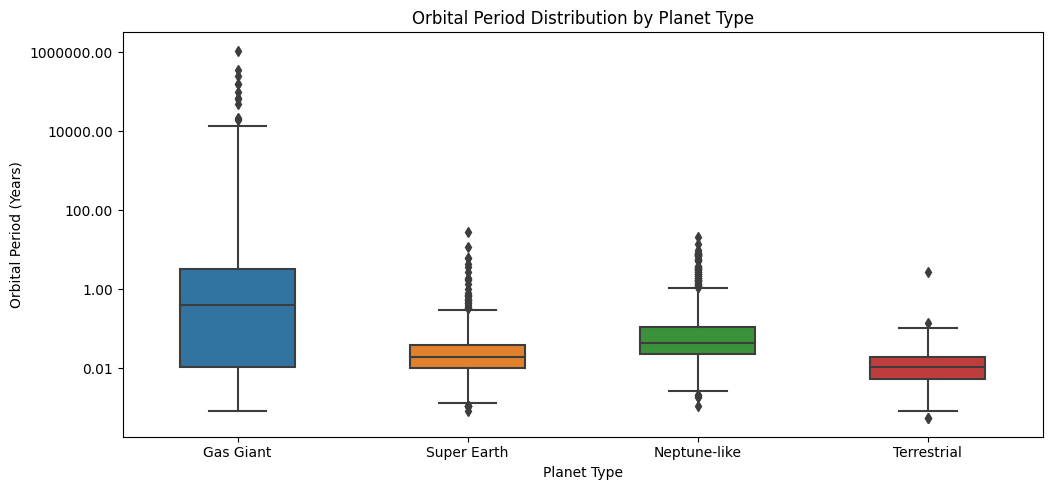

In [23]:
# Planet Type ~ Orbital Period
plt.figure(figsize=(10, 5))
sns.boxplot(x="planet_type", y=log_orbital_period, data=df, width=0.5)
plt.title("Orbital Period Distribution by Planet Type")
plt.xlabel("Planet Type")
plt.ylabel("Orbital Period (Years)")
plt.tight_layout()
plt.gca().yaxis.set_major_formatter(FuncFormatter(log_to_lin))
plt.show()

**Gas giants stand out**
* Much higher median than other planet types
* Much wider IQR and total range than other planet types

# Model Building & Data Labeling

**Assumptions due to limitations of the dataset**
* Host star is Sun-like in terms of effective temperature, variability, stable HZ and metallicity
* Planet receives mean radiant flux comparable to Earth
* Planet has sufficient axial tilt to experience moderate seasons
* Planets rotation around its own axis is quick enough for a not overlong day-night cycle
* Planet has strong magnetic field to shield it from cosmic radiation and solar winds

**Defining attribute ranges for planets to be terrestrial and potentially habitable**
* Mass: 0.1 Earth masses < Planet mass < 10.0 Earth masses
* Radius: 0.5 Earth radii < Planet radius < 2.5 Earth radii
* Eccentricity: Planet orbital eccentricity < 0.2
* Orbital radius: 0.38 AU < Planet orbital radius < 10.0 AU (habitable zone estimates based on our solar system)

Sources: https://en.wikipedia.org/wiki/Planetary_habitability | https://en.wikipedia.org/wiki/Habitable_zone | https://en.wikipedia.org/wiki/List_of_potentially_habitable_exoplanets | https://www.aanda.org/articles/aa/full_html/2016/07/aa28073-16/aa28073-16.html

In [24]:
# Dropping all rows with null values (orbital_radius and distance)
df = df.dropna()

# Defining condition for habitability
condition = (
    (df["mass_earth"] > 0.1) & (df["mass_earth"] < 10.0) &
    (df["radius_earth"] > 0.5) & (df["radius_earth"] < 2.5) &
    (df["eccentricity"] < 0.2) &
    (df["orbital_radius"] > 0.38) & (df["orbital_radius"] < 10.0))

# Labeling data according to habitability condition
df["habitable"] = np.where(condition, True, False)

# Counting planets labeled as habitable
df["habitable"].value_counts()

habitable
False    4856
True       60
Name: count, dtype: int64

**Predicting the habitability of new exoplanets with decision trees**
* Habitability-related attributes as input features
* Boolean "habitable" variable as target feature

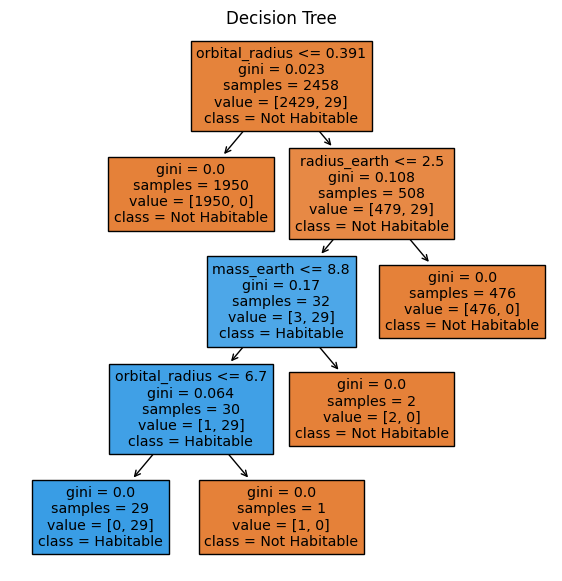

In [25]:
# Defining input and target features
X = df[["mass_earth", "radius_earth", "eccentricity", "orbital_radius"]]
y = df["habitable"]

# Large dataset -> 50:50 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42) 
classifier = DecisionTreeClassifier(random_state=42)
classifier.fit(X_train, y_train)

# Plotting decision tree
plt.figure(figsize=(7, 7))
plot_tree(classifier, filled=True, feature_names=X.columns, class_names=["Not Habitable", "Habitable"])
plt.title("Decision Tree")
plt.show()

In [26]:
# Classifier performance evaluation
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Decision Tree Accuracy:", accuracy)
print("Decision Tree Precision:", precision)
print("Decision Tree Recall:", recall)

Decision Tree Accuracy: 0.9979658258746948
Decision Tree Precision: 0.9333333333333333
Decision Tree Recall: 0.9032258064516129


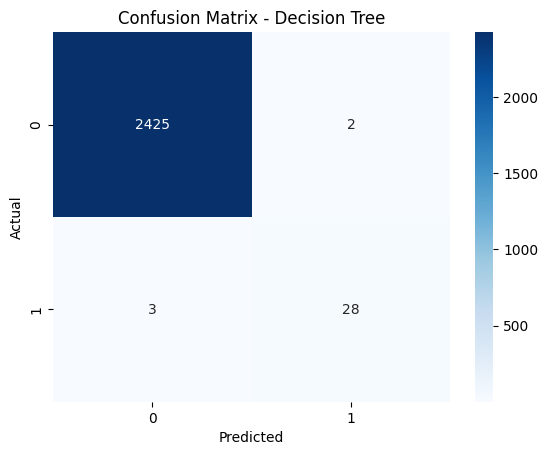

In [27]:
# Plotting confusion matrix for model evaluation
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

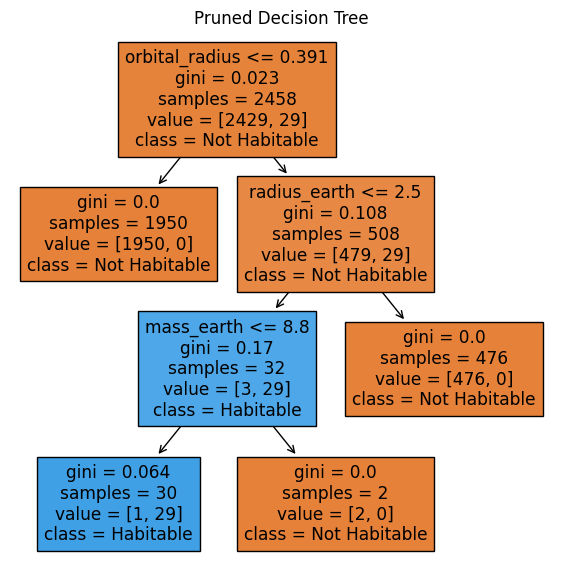

In [28]:
# Pruning decision tree to reduce complexity
pruned = DecisionTreeClassifier(max_depth=3, random_state=42)
pruned.fit(X_train, y_train)

# Plotting pruned decision tree
plt.figure(figsize=(7, 7))
plot_tree(pruned, filled=True, feature_names=X.columns, class_names=["Not Habitable", "Habitable"])
plt.title("Pruned Decision Tree")
plt.show()

In [29]:
# Classifier performance evaluation
y_pred_pruned = pruned.predict(X_test)
accuracy_pruned = accuracy_score(y_test, y_pred_pruned)
precision_pruned = precision_score(y_test, y_pred_pruned)
recall_pruned = recall_score(y_test, y_pred_pruned)
cm2 = confusion_matrix(y_test, y_pred_pruned)

print("Pruned Decision Tree Accuracy:", accuracy_pruned)
print("Pruned Decision Tree Precision:", precision_pruned)
print("Pruned Decision Tree Recall:", recall_pruned)

Pruned Decision Tree Accuracy: 0.9979658258746948
Pruned Decision Tree Precision: 0.9333333333333333
Pruned Decision Tree Recall: 0.9032258064516129


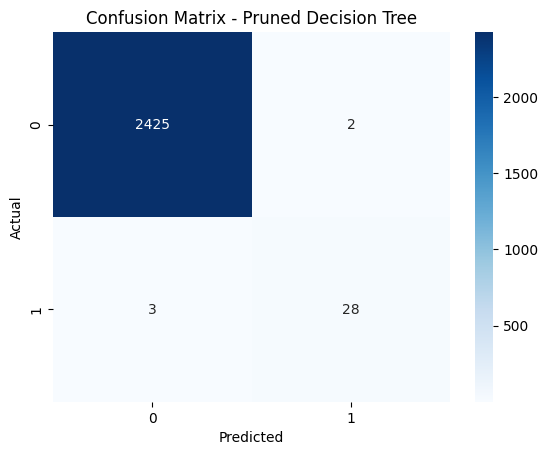

In [30]:
# Plotting confusion matrix for model evaluation
sns.heatmap(cm2, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Pruned Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

**Some methodological issues regarding the decision trees**
* Ranges for habitability-related attributes are based on estimates and hypotheses
* Labeling data based on these strict thresholds may cause overfitting and bias
* Model appears much more accurate than it would actually be with unseen data
* Habitability-related attributes may be influenced by confounding variables 
* **Complexity of habitability estimation is not properly captured by this simple model**

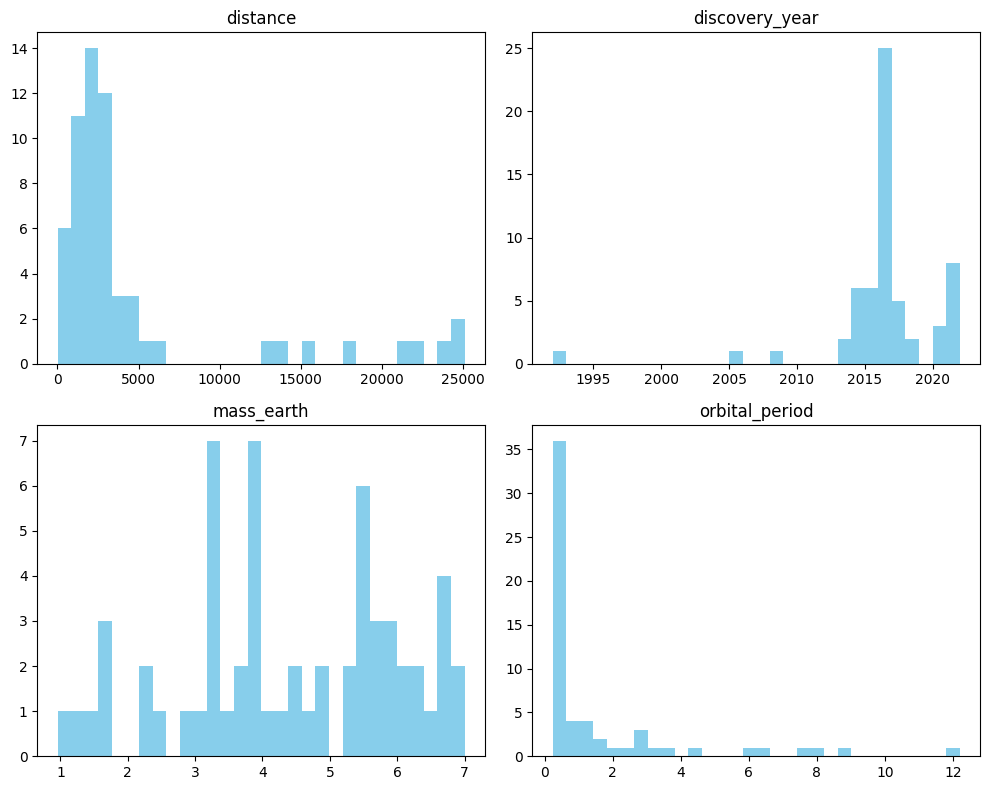

In [31]:
# Brief overview of planets labeled as habitable
pot_hab = df.loc[df["habitable"]==True]
plt_hab = pot_hab[["distance", "discovery_year", "mass_earth", "orbital_period"]]
plt_hab.hist(bins=30, figsize=(10, 8), layout=(2, 2), color="skyblue", grid=False)
plt.tight_layout()
plt.show()

In [32]:
# Listing habitable planets sorted by ascending distance to Earth
pot_hab.sort_values(by="distance", ascending=True).head(15)

,name,distance,planet_type,discovery_year,mass_earth,radius_earth,orbital_radius,orbital_period,eccentricity,detection_method,habitable
4790,Tau Ceti f,12.0,Super Earth,2017,3.93,1.810000,1.3340,1.700000,0.16,Radial Velocity,True
4789,Tau Ceti e,12.0,Super Earth,2017,3.93,1.810000,0.5380,0.445996,0.18,Radial Velocity,True
282,GJ 667 C g,24.0,Super Earth,2013,4.60,1.990000,0.5490,0.701437,0.08,Radial Velocity,True
2946,Kepler-186 f,579.0,Super Earth,2014,1.71,1.170000,0.4320,0.355647,0.04,Transit,True
2158,Kepler-126 d,774.0,Neptune-like,2014,6.80,2.499607,0.4480,0.274606,0.02,Transit,True
2521,Kepler-1540 b,799.0,Neptune-like,2016,6.76,2.488398,0.4426,0.343326,0.00,Transit,True
3719,Kepler-441 b,874.0,Super Earth,2015,3.33,1.640000,0.6400,0.567283,0.10,Transit,True
2639,Kepler-1630 b,1080.0,Neptune-like,2016,5.43,2.190000,1.1218,1.400000,0.00,Transit,True
2528,Kepler-1544 b,1093.0,Super Earth,2016,3.82,1.780000,0.5421,0.462149,0.00,Transit,True
2243,Kepler-132 e,1140.0,Super Earth,2016,1.76,1.180000,0.4393,0.301985,0.00,Transit,True
